# Kaggle Challenge

## Load the data

Install packages

In [1]:
!pip install --user --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /data/home/data-science/.local/lib/python3.5/site-packages
Requirement already up-to-date: scipy>=0.17.0 in /data/anaconda/envs/py35/lib/python3.5/site-packages (from scikit-learn)
Requirement already up-to-date: numpy>=1.11.0 in /data/anaconda/envs/py35/lib/python3.5/site-packages (from scikit-learn)
Requirement already up-to-date: joblib>=0.11 in /data/anaconda/envs/py35/lib/python3.5/site-packages (from scikit-learn)
You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install --user imbalanced-learn

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import pandas as pd
pd.option_context('display.max_columns', 100)
from pandas import read_csv, DataFrame, concat

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12.0, 12.0]
%matplotlib inline

from scipy import stats

import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')

Download the data

In [4]:
base_url = "https://raw.githubusercontent.com/adrienlequiller/Data_Science_Challenge_Kaggle_EDHEC/master/data/"

data_train_raw = pd.read_csv(base_url + 'Xtrain.csv', header=0)  # Training input data
label_train_raw = pd.read_csv(base_url + 'ytrain.csv', header=None)  # Training labels
data_test_raw = pd.read_csv(base_url + 'Xtest.csv', header=0)  # Validation input data

In [5]:
label_train = label_train_raw[0].values.ravel()
label_train

array([2, 1, 3, ..., 1, 3, 2])

## Data exploration

First, let's check the size of our datasets

In [6]:
print('Shape of the training dataset:', data_train_raw.shape)
print('Shape of the validation dataset:', data_test_raw.shape)

Shape of the training dataset: (27204, 31)
Shape of the validation dataset: (54408, 31)


Now let's look at the data

In [7]:
data_train_raw.head()

,month,day,time,light,location,intersection,atmosphere,collision,municipality,department,...,pedaction,pedcondition,birth,dirtraffic,catvehicle,nboccupants,obstacle,movobstacle,impact,maneuver
0,6.0,1.0,1830.0,1.0,1.0,4.0,1.0,1.0,79.0,610.0,...,0.0,0.0,1992.0,2.0,7.0,0.0,0.0,2.0,2.0,1.0
1,3.0,10.0,1530.0,1.0,2.0,1.0,1.0,2.0,8.0,930.0,...,0.0,0.0,1966.0,0.0,7.0,0.0,0.0,0.0,4.0,23.0
2,5.0,17.0,1625.0,1.0,1.0,1.0,1.0,1.0,255.0,740.0,...,0.0,0.0,2002.0,2.0,2.0,0.0,0.0,2.0,1.0,1.0
3,8.0,5.0,1655.0,1.0,1.0,1.0,1.0,6.0,404.0,630.0,...,0.0,0.0,1961.0,1.0,7.0,0.0,4.0,0.0,7.0,1.0
4,10.0,15.0,350.0,3.0,1.0,1.0,1.0,6.0,117.0,130.0,...,0.0,0.0,1999.0,1.0,7.0,0.0,3.0,0.0,1.0,1.0


Then check if we have any missing values

In [8]:
concat([data_train_raw.dtypes, data_train_raw.isna().any(axis=0)], keys=['type', 'missing value?'], axis=1, sort=False)

,type,missing value?
month,float64,False
day,float64,False
time,float64,False
light,float64,False
location,float64,False
intersection,float64,False
atmosphere,float64,True
collision,float64,True
municipality,float64,False
department,float64,False


In visualization, we can't have missing values so let's create a special version of the training dataset for vizualisation purposes

In [9]:
data = data_train_raw.fillna(value=0).copy()
data['severity'] = label_train

The variable severity is categorical with 4 possible values:

1. Unscathed
2. Slight injury
3. Injured in hospital
4. Killed



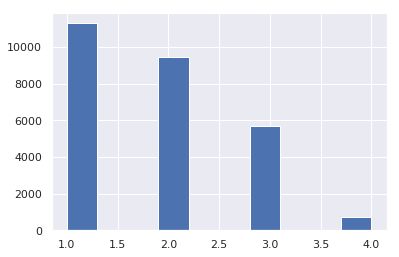

In [10]:
data['severity'].hist();

At this point we might want to know if there is correlation between the features

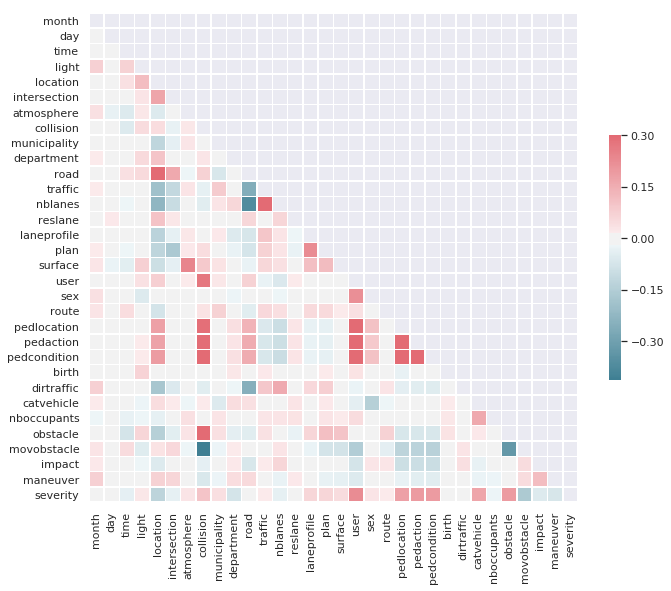

In [11]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

This distribution of `severity` differs depending on the variable it is taken with.

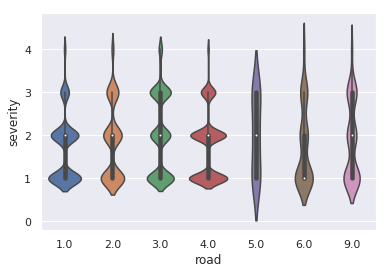

In [12]:
sns.violinplot(y='severity', x='road', data=data);

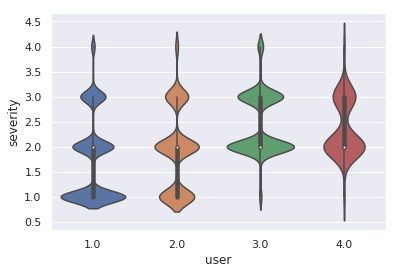

In [13]:
sns.violinplot(y='severity', x='user', data=data);

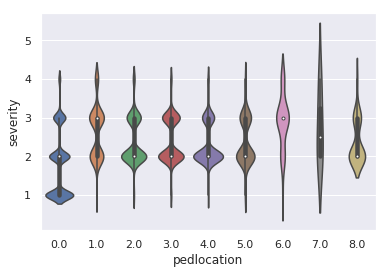

In [14]:
sns.violinplot(y='severity', x='pedlocation', data=data);

## Preprocessing and export for pipeline

Now we need to preprocess the data to handle:

*   Missing values: for numerical values, let's replace the missing values by the median and for categorical values by a new class corresponding to missing
*   Different ranges of values: we don't want a feature to have more importance only because the values are bigger (or higger variance) so let's standardize the numerical values
*   Categorical values: at the moment categorical features have integer values which to not correspond to a scale, so let's create dummy variables for each category instead


First we need to create a helper class that will be used in the preprocessing pipeline after OneHotEncoding to remove highly correlated features

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

# drop higly correlated features
class DropCorrFeatures( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, percent_to_drop = 0.80 ):
        self._percent_to_drop = percent_to_drop 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        # Compute the correlation matrix
        if not isinstance(X, DataFrame):
            X = DataFrame(X)
        
        corr = X.corr().abs()

        # Select upper triangle of correlation matrix
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

        # Find index of feature columns with correlation greater than 0.80
        self._to_drop = [column for column in upper.columns if any(upper[column] >= self._percent_to_drop)]
        return self
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        if not isinstance(X, DataFrame):
            X = DataFrame(X)
            
        X = X.drop(X.columns[self._to_drop], axis=1)
        return X.values

Then, let's create the preprocessing pipeline

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

data_train, data_test = data_train_raw.copy(), data_test_raw.copy()
categories = ['light','location','intersection','pedcondition','atmosphere','collision','road','traffic','reslane','laneprofile','plan','surface','user','sex','route','pedlocation','pedaction','dirtraffic','catvehicle','obstacle','movobstacle','impact','maneuver']
for i in categories:
    data_train[i] = data_train[i].astype('category')
    data_test[i] = data_test[i].astype('category')

numerical_features = data_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data_train.select_dtypes(include=['category']).columns

# replace missing by the median of the columns
# standardize mean and variance of all the columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

# creates new dummmy variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

# creates a preprocessing pipeline for algo that DON'T need OneHotEncoded categories
preprocessor_no_ohe = Pipeline(steps=[
    ('features_transformer', ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', SimpleImputer(strategy='constant', fill_value=-1), categorical_features)
    ])),
])

# creates a preprocessing pipeline for algo that need OneHotEncoded categories
preprocessor = Pipeline(steps=[
    ('features_transformer', ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])),
    ('features_selector', DropCorrFeatures()),
])

## Classification

### Helper functions for classification

Function to draw confusion matrices (regular one and normalized one)

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def confusion_matrices(pipeline, X, y):
    if isinstance(pipeline, Pipeline):
        model = pipeline.best_estimator_[-1]
    else:
        model = pipeline 

    fig, ax = plt.subplots(nrows=len(data), ncols=2, figsize=(12., 12.))

    # For each sample
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    classes = unique_labels(y, y_pred)
    params = {
        "annot": True,
        "cbar": False,
        "cmap": "YlGnBu",
        "vmin": 0,
        "xticklabels": classes,
        "yticklabels": classes
    }

    # Display confusion matrix
    sns.heatmap(cm, ax=ax[0], fmt=".0f", **params)
    ax[0].set(ylabel='True label', xlabel='Predicted label')
    # Display normalized confusion matrix
    sns.heatmap(cm_norm, ax=ax[1], fmt=".2f", **params)
    plt.show()

Function to export predictions to Kaggle

In [30]:
from datetime import datetime

def export(model, X):
    time = datetime.now().strftime('%Y%m%d%H%M')
    if isinstance(model, Pipeline):
        name = type(model.best_estimator_[-1]).__name__ + time
    else:
        name = type(model).__name__ + time
    y_pred = pd.DataFrame(model.predict(X))
    y_pred.to_csv('./output/' + name, index_label='id', header=['prediction'])
    print("{} lines exported".format(y_pred.shape[0]))

### Logistic regression

For logistic regression, there is no need to do a grid search because LogisticRegressionCV already does it.

However we should use OneHotEncoder because the LogisticRegression module in sklearn does not create dummy variables for categorical features.

- Score without OHE: 0.55
- Score with OHE: 0.64

In [40]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(random_state=17, verbose=1, scoring='accuracy', n_jobs=-1, cv=5,
                           multi_class='multinomial', max_iter=10000, solver='lbfgs')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

pipeline.fit(data_train, label_train)

print(pipeline.score(data_train, label_train))

print(pipeline[-1].l1_ratio_)
print(pipeline[-1].C_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min finished


0.6432142332009999
[None None None None]
[21.5443469 21.5443469 21.5443469 21.5443469]


In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=17, max_iter=1000, solver='saga')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

param_grid = {
    'classifier__multi_class': ['multinomial'], # multinomial always better than ovr
    'classifier__penalty': ['elasticnet'],
    'classifier__l1_ratio': [0, 0.1, 0.25, 0.5, 0.75, 0.90, 1],
    'classifier__C': [10 ** x for x in range(-4, 5)],
}

gs = RandomizedSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
gs.fit(data_train, label_train)

print(gs.best_params_)
print(gs.best_score_)
results = pd.DataFrame(gs.cv_results_)
results.sort_values(by="mean_test_score", ascending=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 20.0min finished


{'classifier__penalty': 'elasticnet', 'classifier__multi_class': 'multinomial', 'classifier__C': 100, 'classifier__l1_ratio': 0.5}
0.6332157035730039


,mean_fit_time,mean_score_time,mean_test_score,param_classifier__C,param_classifier__l1_ratio,param_classifier__multi_class,param_classifier__penalty,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
2,282.139304,0.080871,0.633216,100,0.5,multinomial,elasticnet,"{'classifier__penalty': 'elasticnet', 'classif...",1,0.627527,0.640691,0.634810,0.626471,0.636581,2.734779,0.002314,0.005433
3,262.605155,0.077949,0.633142,1,0.75,multinomial,elasticnet,"{'classifier__penalty': 'elasticnet', 'classif...",2,0.628997,0.639956,0.634994,0.626654,0.635110,2.576446,0.005072,0.004754
7,277.484678,0.083169,0.633142,10000,1,multinomial,elasticnet,"{'classifier__penalty': 'elasticnet', 'classif...",2,0.627527,0.640323,0.634810,0.626654,0.636397,2.164691,0.005084,0.005264
1,285.265326,0.095142,0.633105,1000,0.25,multinomial,elasticnet,"{'classifier__penalty': 'elasticnet', 'classif...",4,0.627527,0.640323,0.634810,0.626471,0.636397,7.693214,0.015065,0.005310
8,247.401503,0.069587,0.633105,100,0.1,multinomial,elasticnet,"{'classifier__penalty': 'elasticnet', 'classif...",4,0.627527,0.640323,0.634810,0.626471,0.636397,32.503864,0.030574,0.005310
5,185.582373,0.084241,0.632995,1,0,multinomial,elasticnet,"{'classifier__penalty': 'elasticnet', 'classif...",6,0.628078,0.639588,0.634810,0.625735,0.636765,1.546808,0.010697,0.005251
9,80.299385,0.063652,0.626856,0.01,0.1,multinomial,elasticnet,"{'classifier__penalty': 'elasticnet', 'classif...",7,0.618155,0.630215,0.631318,0.623529,0.631066,6.666298,0.020534,0.005210
0,142.434172,0.098074,0.610425,0.01,0.75,multinomial,elasticnet,"{'classifier__penalty': 'elasticnet', 'classif...",8,0.598493,0.616247,0.612939,0.611029,0.613419,10.686211,0.004097,0.006196
4,13.151536,0.078751,0.415490,0.0001,0.9,multinomial,elasticnet,"{'classifier__penalty': 'elasticnet', 'classif...",9,0.415472,0.415549,0.415549,0.415441,0.415441,0.227194,0.002611,0.000049
6,18.365362,0.091048,0.415490,0.0001,0.75,multinomial,elasticnet,"{'classifier__penalty': 'elasticnet', 'classif...",9,0.415472,0.415549,0.415549,0.415441,0.415441,3.230424,0.011429,0.000049


## SVM

#### Kernelized SVM

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

clf = SVC(random_state=17, kernel='rbf', class_weight='balanced')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

param_grid = {
    'classifier__C': [1, 5, 10, 50],
    'classifier__gamma': [0.0001, 0.0005, 0.001, 0.005],
}

gs = RandomizedSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
gs.fit(data_train, label_train)

print(gs.best_params_)
print(gs.best_score_)
results = pd.DataFrame(gs.cv_results_)
results.sort_values(by="mean_test_score", ascending=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 37.5min finished


{'classifier__gamma': 0.005, 'classifier__C': 10}
0.5935891780620497


,mean_fit_time,mean_score_time,mean_test_score,param_classifier__C,param_classifier__gamma,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
9,246.051086,29.156555,0.593589,10,0.005,"{'classifier__gamma': 0.005, 'classifier__C': 10}",1,0.586549,0.602647,0.595295,0.589154,0.594301,16.395543,0.825284,0.005562
2,271.720573,35.263897,0.585355,5,0.005,"{'classifier__gamma': 0.005, 'classifier__C': 5}",2,0.579566,0.594008,0.587208,0.582721,0.583272,4.518608,2.271664,0.004962
8,270.904170,34.393912,0.578334,50,0.001,"{'classifier__gamma': 0.001, 'classifier__C': 50}",3,0.574054,0.586841,0.583900,0.569853,0.577022,3.922725,2.520801,0.006250
6,276.327756,34.347697,0.569659,50,0.0005,"{'classifier__gamma': 0.0005, 'classifier__C':...",4,0.563028,0.578386,0.571402,0.563787,0.571691,5.053548,0.243694,0.005688
5,289.820570,36.559973,0.561939,1,0.005,"{'classifier__gamma': 0.005, 'classifier__C': 1}",5,0.558067,0.565889,0.560926,0.559559,0.565257,3.318835,0.535277,0.003108
7,286.347157,38.239189,0.556168,50,0.0001,"{'classifier__gamma': 0.0001, 'classifier__C':...",6,0.551268,0.565153,0.552840,0.551838,0.559743,3.926642,2.836285,0.005429
3,303.779286,37.761304,0.550176,5,0.0005,"{'classifier__gamma': 0.0005, 'classifier__C': 5}",7,0.547042,0.558353,0.545304,0.544853,0.555331,2.698995,1.574065,0.005574
0,346.698626,39.133551,0.537825,10,0.0001,"{'classifier__gamma': 0.0001, 'classifier__C':...",8,0.538221,0.542547,0.529314,0.534743,0.544301,2.232423,0.850792,0.005410
1,369.748181,43.111687,0.530216,5,0.0001,"{'classifier__gamma': 0.0001, 'classifier__C': 5}",9,0.527747,0.534461,0.524352,0.530331,0.534191,5.076813,2.052960,0.003855
4,362.492416,40.274175,0.529702,1,0.0005,"{'classifier__gamma': 0.0005, 'classifier__C': 1}",10,0.527747,0.533725,0.523985,0.530147,0.532904,2.710189,0.173732,0.003554


## Ensemble methods

### Random Forest

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=17, n_estimators=300)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

param_grid = {
    'classifier__n_estimators': [1000],
    'classifier__max_depth': [30],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf' : [2],
    'classifier__criterion': ['gini'],
    'classifier__class_weight': ['balanced'],
}

gs = RandomizedSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
gs.fit(data_train, label_train)

print(gs.best_params_)
print(gs.best_score_)
results = pd.DataFrame(gs.cv_results_)
results.sort_values(by="mean_test_score", ascending=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   54.0s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


{'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__criterion': 'gini', 'classifier__n_estimators': 1000, 'classifier__class_weight': 'balanced', 'classifier__max_depth': 30}
0.6462652551095427


,mean_fit_time,mean_score_time,mean_test_score,param_classifier__class_weight,param_classifier__criterion,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,59.557205,1.424079,0.646265,balanced,gini,30,2,2,1000,"{'classifier__min_samples_split': 2, 'classifi...",1,0.633774,0.658702,0.652821,0.638419,0.64761,9.988445,0.029946,0.009133


### AdaBoost

In [23]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(random_state=17, n_estimators=300, learning_rate=0.05)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

param_grid = {
    'classifier__algorithm' : ['SAMME', 'SAMME.R'],
}

gs = RandomizedSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
gs.fit(data_train, label_train)

print(gs.best_params_)
print(gs.best_score_)
results = pd.DataFrame(gs.cv_results_)
results.sort_values(by="mean_test_score", ascending=False)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   55.9s remaining:   37.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished


{'classifier__algorithm': 'SAMME.R'}
0.5930745478606088


,mean_fit_time,mean_score_time,mean_test_score,param_classifier__algorithm,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
1,40.603048,1.020569,0.593075,SAMME.R,{'classifier__algorithm': 'SAMME.R'},1,0.588203,0.592722,0.603014,0.589890,0.591544,11.554693,0.233077,0.005199
0,52.489732,0.833829,0.547677,SAMME,{'classifier__algorithm': 'SAMME'},2,0.541345,0.545120,0.551002,0.562316,0.538603,2.699596,0.176607,0.008418


### LightGBM

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

clf = LGBMClassifier(random_state=17, n_estimators=300, learning_rate=0.05, objective='multiclass', num_class=4)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_no_ohe),
    ('classifier', clf)
])

param_grid = {
    'classifier__subsample': [0.8], # >0.7; <0.9
    'classifier__max_depth': [7], # soit 7 soit -1 pas d'autres valeurs
    'classifier__colsample_bytree': [0.75], # 0.75
    'classifier__boosting': ['gbrt'], # keep 'gbrt' in ['gbrt', 'dart', 'goss']
    'classifier__min_child_weight': [0.0001], # keep it > 0.0001
    'classifier__lambda_l1': [1],
    'classifier__lambda_l2': [5],
}

gs = RandomizedSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
gs.fit(data_train, label_train)

print(gs.best_params_)
print(gs.best_score_)
results = pd.DataFrame(gs.cv_results_)
results.sort_values(by="mean_test_score", ascending=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


{'classifier__lambda_l2': 5, 'classifier__lambda_l1': 1, 'classifier__subsample': 0.8, 'classifier__min_child_weight': 0.0001, 'classifier__colsample_bytree': 0.75, 'classifier__boosting': 'gbrt', 'classifier__max_depth': 7}
0.6524040582267313


,mean_fit_time,mean_score_time,mean_test_score,param_classifier__boosting,param_classifier__colsample_bytree,param_classifier__lambda_l1,param_classifier__lambda_l2,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__subsample,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,5.396184,0.602932,0.652404,gbrt,0.75,1,5,7,0.0001,0.8,"{'classifier__lambda_l2': 5, 'classifier__lamb...",1,0.643697,0.661459,0.660724,0.645221,0.650919,0.851908,0.017912,0.007495


### XGBoost

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

clf = XGBClassifier(random_state=17, n_estimators=300, learning_rate=0.05, objective='multiclass', num_class=4)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_no_ohe),
    ('classifier', clf)
])

param_grid = {
    'classifier__subsample': [0.8],
    'classifier__max_depth': [7],
    'classifier__colsample_bytree': [0.75],
    'classifier__boosting': ['gbrt'],
    'classifier__min_child_weight': [0.0001],
    'classifier__lambda_l1': [1],
    'classifier__lambda_l2': [5],
}

gs = RandomizedSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
gs.fit(data_train, label_train)

print(gs.best_params_)
print(gs.best_score_)
results = pd.DataFrame(gs.cv_results_)
results.sort_values(by="mean_test_score", ascending=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.8s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.2s finished


{'classifier__lambda_l2': 5, 'classifier__lambda_l1': 1, 'classifier__subsample': 0.8, 'classifier__min_child_weight': 0.0001, 'classifier__colsample_bytree': 0.75, 'classifier__boosting': 'gbrt', 'classifier__max_depth': 7}
0.6539111895309513


,mean_fit_time,mean_score_time,mean_test_score,param_classifier__boosting,param_classifier__colsample_bytree,param_classifier__lambda_l1,param_classifier__lambda_l2,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__subsample,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,46.52742,0.648283,0.653911,gbrt,0.75,1,5,7,0.0001,0.8,"{'classifier__lambda_l2': 5, 'classifier__lamb...",1,0.650496,0.661827,0.662011,0.650368,0.644853,6.471215,0.03224,0.006849


### Neural networks

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers


def baseline_model(inputs = 200, units = 128, layers = 3, dropout = 0.1):
    # create model
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim = inputs))
    model.add(Dropout(rate=dropout))
    for i in range(1, layers):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(rate=dropout))
    model.add(Dense(4, activation='softmax'))
    
    # Compile model
    optimizers.Adam(lr=0.0005, decay=0.01)
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

def plot_metric(metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

data_train_ohe = preprocessor.fit_transform(data_train)

clf = KerasClassifier(
    build_fn=baseline_model,
    epochs=20, batch_size=200, validation_split=0.2, verbose=1
)

param_grid = {
    'inputs': [data_train_ohe.shape[1]], # should be equal to the numbers of features in the input 
    'layers': [3, 4, 5],
    'units': [200, 500],
    'dropout': [0.2, 0.3, 0.4],
}

gs = RandomizedSearchCV(clf, param_grid, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)

gs.fit(data_train_ohe, label_train)

print(gs.best_params_)
print(gs.best_score_)
results = pd.DataFrame(gs.cv_results_)
results.sort_values(by="mean_test_score", ascending=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.8min


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.8min finished


Train on 21763 samples, validate on 5441 samples
Epoch 1/20
21763/21763 [==============================] - 1s 37us/step - loss: 1.0749 - acc: 0.4922 - val_loss: 0.9027 - val_acc: 0.6230
Epoch 2/20
21763/21763 [==============================] - 0s 22us/step - loss: 0.9188 - acc: 0.5977 - val_loss: 0.8586 - val_acc: 0.6322
Epoch 3/20
21763/21763 [==============================] - 0s 22us/step - loss: 0.8752 - acc: 0.6189 - val_loss: 0.8462 - val_acc: 0.6341
Epoch 4/20
21763/21763 [==============================] - 0s 22us/step - loss: 0.8554 - acc: 0.6280 - val_loss: 0.8358 - val_acc: 0.6383
Epoch 5/20
21763/21763 [==============================] - 0s 22us/step - loss: 0.8425 - acc: 0.6366 - val_loss: 0.8288 - val_acc: 0.6405
Epoch 6/20
21763/21763 [==============================] - 0s 22us/step - loss: 0.8285 - acc: 0.6436 - val_loss: 0.8297 - val_acc: 0.6434
Epoch 7/20
21763/21763 [==============================] - 0s 22us/step - loss: 0.8129 - acc: 0.6525 - val_loss: 0.8345 - val_acc:

,mean_fit_time,mean_score_time,mean_test_score,param_dropout,param_inputs,param_layers,param_units,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
1,28.267680,0.286743,0.637075,0.4,200,3,200,"{'layers': 3, 'units': 200, 'dropout': 0.4, 'i...",1,0.632788,0.636831,0.643448,0.631869,0.640441,0.796263,0.046864,0.004416
8,35.908254,0.382178,0.630496,0.4,200,4,200,"{'layers': 4, 'units': 200, 'dropout': 0.4, 'i...",2,0.617166,0.633891,0.642161,0.624150,0.635110,0.580158,0.050320,0.008796
4,169.310762,1.039820,0.620129,0.4,200,5,500,"{'layers': 5, 'units': 500, 'dropout': 0.4, 'i...",3,0.614409,0.626539,0.619555,0.623231,0.616912,5.059559,0.061098,0.004338
2,100.707443,0.572728,0.616490,0.4,200,3,500,"{'layers': 3, 'units': 500, 'dropout': 0.4, 'i...",4,0.614042,0.615144,0.624518,0.610733,0.618015,3.303751,0.105822,0.004641
5,35.997438,0.473014,0.615608,0.2,200,4,200,"{'layers': 4, 'units': 200, 'dropout': 0.2, 'i...",5,0.611836,0.625804,0.625437,0.601176,0.613787,0.246074,0.135345,0.009235
9,39.007501,0.307620,0.614763,0.2,200,5,200,"{'layers': 5, 'units': 200, 'dropout': 0.2, 'i...",6,0.607241,0.613858,0.619739,0.613490,0.619485,0.599777,0.070676,0.004606
3,139.181062,0.758681,0.614468,0.4,200,4,500,"{'layers': 4, 'units': 500, 'dropout': 0.4, 'i...",7,0.614593,0.613306,0.616798,0.609998,0.617647,4.163574,0.051800,0.002716
6,174.003017,1.101040,0.613182,0.3,200,5,500,"{'layers': 5, 'units': 500, 'dropout': 0.3, 'i...",8,0.599155,0.616063,0.622312,0.609079,0.619301,5.440706,0.079382,0.008279
0,130.325694,0.672545,0.611013,0.3,200,4,500,"{'layers': 4, 'units': 500, 'dropout': 0.3, 'i...",9,0.610917,0.615879,0.605771,0.606874,0.615625,0.560925,0.071947,0.004233
7,133.185537,0.578202,0.590354,0.2,200,4,500,"{'layers': 4, 'units': 500, 'dropout': 0.2, 'i...",10,0.582613,0.592171,0.589414,0.584084,0.603493,8.918961,0.180498,0.007430


Train on 21763 samples, validate on 5441 samples
Epoch 1/10
21763/21763 [==============================] - 1s 55us/step - loss: 1.1321 - acc: 0.4316 - val_loss: 0.9966 - val_acc: 0.5600
Epoch 2/10
21763/21763 [==============================] - 1s 34us/step - loss: 0.9667 - acc: 0.5703 - val_loss: 0.8811 - val_acc: 0.6273
Epoch 3/10
21763/21763 [==============================] - 1s 32us/step - loss: 0.9085 - acc: 0.6043 - val_loss: 0.8712 - val_acc: 0.6262
Epoch 4/10
21763/21763 [==============================] - 1s 33us/step - loss: 0.8773 - acc: 0.6240 - val_loss: 0.8579 - val_acc: 0.6310
Epoch 5/10
21763/21763 [==============================] - 1s 33us/step - loss: 0.8582 - acc: 0.6306 - val_loss: 0.8354 - val_acc: 0.6346
Epoch 6/10
21763/21763 [==============================] - 1s 32us/step - loss: 0.8444 - acc: 0.6377 - val_loss: 0.8381 - val_acc: 0.6354
Epoch 7/10
21763/21763 [==============================] - 1s 33us/step - loss: 0.8376 - acc: 0.6404 - val_loss: 0.8328 - val_acc:

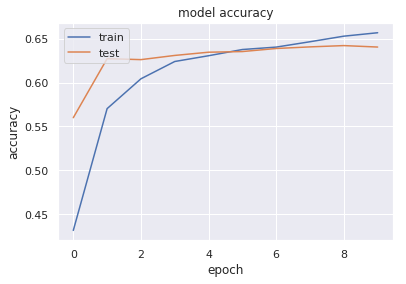

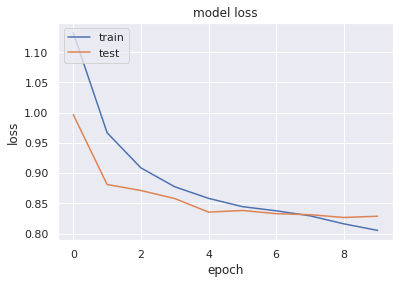

In [28]:
from keras.wrappers.scikit_learn import KerasClassifier

data_train_ohe = preprocessor.fit_transform(data_train)

params = {
    'inputs': data_train_ohe.shape[1], # should be equal to the numbers of features in the input 
    'layers': 5,
    'units': 200,
    'dropout': 0.4,
}

estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=200, validation_split=0.2, verbose=1, **params)

history = estimator.fit(data_train_ohe, label_train)

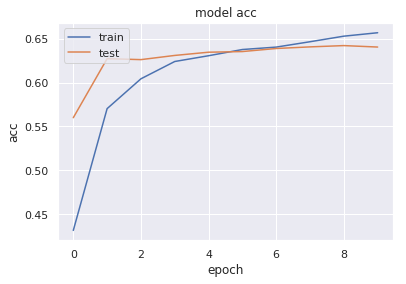

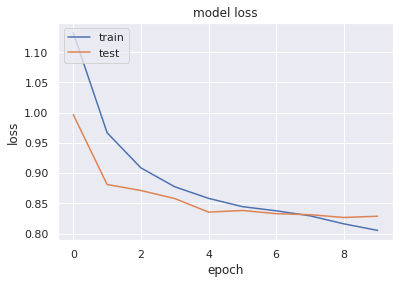

In [35]:
plot_metric('acc')
plot_metric('loss')

## Exportation

In [ ]:
# For Neural network
# export(gs, preprocessor.transform(data_test))

# For other models
export(gs, data_test)